# Set up

In [2316]:
# Install packages

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2317]:
# Setting the Seed (pandas, statsmodels, matplotlib and y_data_profiling rely on 
# numpy's random generator, and thus, we need to set the seed in numpy)
seed = 2024
np.random.seed(seed)

In [2318]:
# Importing the data 
diet_df = pd.read_csv("diet.csv")
recipes_df = pd.read_csv("recipes.csv")
requests_df = pd.read_csv("requests.csv")
reviews_df = pd.read_csv("reviews.csv")

/var/folders/wd/38kzp1bn5139zlz7q02hldnw0000gn/T/ipykernel_83612/2370802839.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_df = pd.read_csv("reviews.csv")


## Cleaning diet.csv

In [2319]:
diet_df

,AuthorId,Diet,Age
0,10000120E,Vegetarian,46
1,1000014D,Vegan,18
2,1000015A,Vegetarian,58
3,1000016E,Vegetarian,32
4,1000027E,Vegan,61
...,...,...,...
271902,999917E,Vegetarian,28
271903,999936C,Omnivore,22
271904,99993D,Vegetarian,58
271905,99994A,Vegetarian,18


In [2320]:
# Dataset is already clean, only one missing value -> replace with most common diet

# Clean Diet
diet_cleaned = diet_df 

# Replace the missing values with the most common diet
diet_cleaned.loc[diet_cleaned["AuthorId"] == "646062A", "Diet"] = "Vegetarian"

# Dummy Encode the diet column to int64
diet_cleaned = pd.get_dummies(diet_cleaned, columns=["Diet"], prefix=["Diet"])

In [2321]:
# cut the Age column into 4 eqaully sized bins (18-33), (34-48), (49-63), (64-79)
diet_cleaned["Age_Group"] = pd.cut(diet_cleaned["Age"], bins=4, labels=["Young_Adults", "Middle_Adults", "Old_Adults", "Seniors"])


In [2322]:
# dummy encode the age groups
diet_cleaned = pd.get_dummies(diet_cleaned, columns=["Age_Group"])

In [2323]:
diet_cleaned.dtypes

AuthorId                   object
Age                         int64
Diet_Omnivore               uint8
Diet_Vegan                  uint8
Diet_Vegetarian             uint8
Age_Group_Young_Adults      uint8
Age_Group_Middle_Adults     uint8
Age_Group_Old_Adults        uint8
Age_Group_Seniors           uint8
dtype: object

## Cleaning requests.csv

In [2324]:
requests_cleaned = requests_df.copy()

In [2325]:
requests_cleaned

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1799.950949,0.0,Indifferent,0,0,0
1,437641B,365718,4201.820980,0.0,Yes,0,Indifferent,1
2,1803340263D,141757,6299.861496,0.0,Indifferent,1,Indifferent,0
3,854048B,280351,19801.365796,0.0,Yes,1,0,1
4,2277685E,180505,5400.093457,0.0,Indifferent,0,0,0
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1560.649725,0.0,Indifferent,0,0,1
140191,33888B,333262,1502.011466,1.0,Indifferent,1,0,0
140192,401942C,49200,5999.274269,0.0,Indifferent,0,0,1
140193,346866B,214815,899.523513,0.0,Yes,1,Indifferent,1


In [2326]:
# Replace negative Time values with 0 (other option: Really high value)
requests_cleaned.loc[requests_cleaned["Time"] < 0, "Time"] = 0

# convert the Time column to int64
requests_cleaned["Time"] = requests_cleaned["Time"].astype("int")

In [2327]:
# make column HighCalories integer with no decimal places
requests_cleaned["HighCalories"] = requests_cleaned["HighCalories"].astype("int")

In [2328]:
# Handling the HighProtein column
requests_cleaned['HighProtein'] = requests_df['HighProtein'].map({'Yes': 1, 'Indifferent': 0})

# Handling the LowSugar column
requests_cleaned['LowSugar'] = requests_df['LowSugar'].map({'0': 1, 'Indifferent': 0})

In [2329]:
# Make column for healty requests if HighProtein is 1, LowFat is 1 and HighFiber is 1
# What to do with sugar? -> Difficult to classify
requests_cleaned['Healthy'] = np.where((requests_cleaned['HighCalories'] == 0) & (requests_cleaned['HighProtein'] == 1) & (requests_cleaned['LowFat'] == 1) & (requests_cleaned['HighFiber'] == 1), 1, 0)

In [2330]:
requests_cleaned

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Healthy
0,2001012259B,73440,1799,0,0,0,1,0,0
1,437641B,365718,4201,0,1,0,0,1,0
2,1803340263D,141757,6299,0,0,1,0,0,0
3,854048B,280351,19801,0,1,1,1,1,1
4,2277685E,180505,5400,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
140190,163793B,78171,1560,0,0,0,1,1,0
140191,33888B,333262,1502,1,0,1,1,0,0
140192,401942C,49200,5999,0,0,0,1,1,0
140193,346866B,214815,899,0,1,1,0,1,1


## Cleaning reviews.csv

In [2331]:
reviews_cleaned = reviews_df.copy()

In [2332]:
# drop Rating column
#reviews_cleaned.drop(columns=["Rating"], inplace=True)

# Handling the Like Column 
reviews_cleaned['Like'] = reviews_cleaned['Like'].map({True: 1, False: 0})

In [2333]:
reviews_cleaned

,AuthorId,RecipeId,Rating,Like,TestSetId
0,2492191A,33671,2.0,NaN,1.0
1,2002019979A,92647,2.0,NaN,2.0
2,408594E,161770,NaN,NaN,3.0
3,2001625557E,108231,2.0,NaN,4.0
4,2001427116E,71109,NaN,NaN,5.0
...,...,...,...,...,...
140190,999595E,338070,2.0,0.0,NaN
140191,999774A,29002,2.0,0.0,NaN
140192,999774A,159252,NaN,0.0,NaN
140193,999774A,1171,2.0,1.0,NaN


## Cleaning recipes.csv

In [2334]:
recipes_cleaned = recipes_df.copy()

In [2335]:
# in RecipeServings, replace the missing values with the median -> BRINGT NICHTS!!!
# recipes_cleaned["RecipeServings"].fillna(recipes_cleaned["RecipeServings"].median(), inplace=True)

In [2336]:
recipes_df['RecipeCategory'].value_counts()

Other            56347
Lunch             4887
One dish meal     4590
Bread             4246
Breakfast         3033
Beverages         2303
Soup               198
Name: RecipeCategory, dtype: int64

In [2337]:
# show some recipes where RecipeCategory is One Dish Meal

recipes_df.loc[recipes_df["RecipeCategory"] == "Lunch"]

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield
40,162015,Dragon Fruit Boats,1200,900,Lunch,"c(""\""1\"""", ""\""1\"""", ""\""2\"""", ""\""1\"""", ""\""2\"""",...","c(""\""boneless chicken breast\"""", ""\""baby shrim...",53.6,0.4,0.1,0.2,154.9,12.1,0.9,8.4,0.8,4.0,NaN
45,101619,The Siciliano Sandwich (Roma Cafe Remake),1200,900,Lunch,"c(""\""2\"""", ""\""8\"""", ""\""2\"""", ""\""4\"""", ""\""4\"""",...","c(""\""parmesan cheese\"""", ""\""provolone cheese\""...",272.2,10.4,5.7,22.2,1399.6,31.5,3.5,2.8,13.7,4.0,4 Sandwiches
55,56518,Sweet Potato Chips,1200,600,Lunch,"""1 -2""","c(""\""olive oil\"""", ""\""sweet potato\"""")",27.9,0.0,0.0,0.0,17.9,6.5,1.0,1.4,0.5,NaN,NaN
82,238798,"Ham, Cheese &amp; Coleslaw Hero",0,600,Lunch,"c(""\""1/2\"""", ""\""2\"""", ""\""1\"""", ""\""2\"""", ""\""1/4...","c(""\""plain low-fat yogurt\"""", ""\""light mayonna...",472.1,18.9,8.5,58.3,2427.5,51.9,5.4,6.5,24.1,4.0,NaN
84,406380,English Breakfast Quiche,3300,1200,Lunch,"c(""\""300\"""", ""\""150\"""", ""\""1/2\"""", ""\""1\"""", ""\...","c(""\""plain flour\"""", ""\""butter\"""", ""\""salt\"""",...",437.3,31.0,16.6,134.1,345.9,32.4,1.6,2.2,8.2,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75509,71494,Grilled Cheese With Thousand Island Dressing,1200,600,Lunch,"c(""\""8\"""", ""\""2\"""", ""\""8\"""", ""\""12\"""", ""\""4\"""")","c(""\""bacon\"""", ""\""unsalted butter\"""", ""\""chees...",835.3,41.8,20.6,84.8,1751.8,81.8,3.2,5.7,33.9,4.0,NaN
75521,457138,Energy Health Bars,1800,600,Lunch,"c(""\""1/2\"""", ""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\...","c(""\""honey\"""", ""\""peanut butter\"""", ""\""salt\""""...",235.6,18.1,2.1,0.0,84.3,15.8,3.2,9.2,6.7,18.0,18
75525,158642,Diet -- Chewy Crunchy Snack Bars,60,1800,Lunch,"c(""\""1\"""", ""\""1/2\"""", ""\""1/4\"""", ""\""1/2\"""", ""\...","c(""\""rolled oats\"""", ""\""wheat germ\"""", ""\""pean...",166.7,6.1,1.2,0.0,67.4,26.3,1.7,18.6,4.5,8.0,8 bars
75561,266272,Raw Vegan &quot;Pad Thai&quot;,0,1200,Lunch,"c(""\""2\"""", ""\""1\"""", ""\""2/3\"""", ""\""2\"""", ""\""1\""...","c(""\""daikon radish\"""", ""\""tahini\"""", ""\""lime\""...",948.2,27.1,4.8,143.6,110.0,148.1,13.5,11.8,33.3,4.0,NaN


In [2338]:
# # Try to categorize recipes with category Other
# category_keywords = {
#     'Breakfast': ['breakfast', 'morning', 'brunch', 'pancake', 'smoothie', 'eggs', 'egg', 'muffin', 'muffins', 'waffle', 'waffle' 'french toast', 'omelet', 'crepe', 'crepes', 'frittata', 'quiche', 'hash', 'scramble', 'bagel', 'cereal', 'granola', 'oatmeal', 'porridge', 'toast', 'jam'],
#     'Lunch': ['lunch', 'noon', 'sandwich', 'wrap', 'salad'],
#     'Beverages': ['drink', 'beverage', 'smoothie', 'lemonade', 'cocktail', 'coffee', 'tea', 'sangria', 'punch', 'cocoa', 'cider', 'eggnog', 'milkshake', 'margarita', 'beer', 'soda'],
#     'Soup': ['soup', 'stew', 'chowder', 'gumbo'],
#     'Bread': ['bread', 'biscuit', 'scone', 'roll', 'loaf'],
#     # One dish??? How to classify? -> Maybe throw it out
# }

# # Function to classify recipe category based on keywords
# def classify_category(recipe_name):
#     for category, keywords in category_keywords.items():
#         if any(keyword in recipe_name.lower() for keyword in keywords):
#             return category
#     return 'Other'

# # Apply the function to all rows where the current category is 'Other'

# recipes_cleaned.loc[recipes_cleaned["RecipeCategory"] == "Other", "RecipeCategory"] = recipes_cleaned.loc[recipes_cleaned["RecipeCategory"] == "Other", "Name"].apply(classify_category)
# #recipes_df['RecipeCategory'] = recipes_df['Name'].apply(classify_category)

# recipes_cleaned.sample(20)

# BRINGT GAR NICHTS!!!

In [2339]:
# create beverage column -> BRINGT NICHTS!!!
#recipes_cleaned['Beverage'] = np.where((recipes_cleaned['RecipeCategory'] == 'Beverages'), 1, 0)

In [2340]:
# create column for Desserts -> BRINGT NICHTS!!!

#dessert_string = 'cake|cupcake|brownie|cookie|pie|tart|cheesecake|pudding|mousse|ice cream|gelato|sorbet|frozen yogurt|parfait|trifle|cobbler|crisp|crumble|pastry|baklava|churro|donut|eclair|macaron|marshmallow|muffin|panna cotta|popsicle|sherbet|shortcake|souffle|strudel|tiramisu|crepe|fritter|flan|custard|pudding|blondie|fondant|torte|biscotti|cannoli|pavlova|caramel|fudge|gingerbread|jelly|lemon bar|nanaimo bar|petit four|scone'
#recipes_cleaned['Dessert'] = np.where((recipes_cleaned['Name'].str.contains(dessert_string)) & (recipes_cleaned['Beverage'] == 0), 1, 0)

In [2341]:
# create breakfast column -> BRINGT NICHTS!!!
# recipes_cleaned['Breakfast'] = np.where((recipes_cleaned['RecipeCategory'] == 'Breakfast'), 1, 0)

In [2342]:
# Creating extra categories doesnt give value
# Handling the RecipeCategory column
recipes_cleaned = pd.get_dummies(recipes_cleaned, columns=['RecipeCategory'])

In [2343]:
# calculate total time as the sum of prep time and cook time
recipes_cleaned["TotalTime"] = recipes_cleaned["PrepTime"] + recipes_cleaned["CookTime"]

In [2344]:
# Look for specific ingredients in the RecipeIngredientParts column
recipes_cleaned['Meat'] = recipes_cleaned['RecipeIngredientParts'].str.contains('chicken|beef|pork|lamb|turkey|duck|goose|fish|seafood|salmon|shrimp|crab|lobster|ham|bacon|sausage|meat|steak|veal|venison|bison|liver|lamb|poultry|meat|tuna|mackerel|trout|haddock|cod|catfish|tilapia|sardine|anchovy|halibut|swordfish|monkfish|eel|octopus|squid|clams|mussels|oysters|snail|game|partridge|pheasant|quail|rabbit|hare|wild boar|elk|moose|reindeer|buffalo|ostrich|emu|kangaroo|alligator|frog legs|snapper|grouper|barracuda|carp|pike|perch|flounder|sole|mahi mahi|red snapper|swordfish|branzino|char|chub|mullet|ray|skate|sturgeon|turbot|whiting|arctic char|caviar|roe|scallop|sea urchin|abalone|crayfish|langoustine|prawn|cuttlefish|jellyfish|stingray|barramundi|black cod|bluefish|bonito|bream|burbot|butterfish|capelin|chimaera|conger|coral trout|dab|dace|dogfish|dorado|dory|drum|escolar|garfish|gilt-head bream|hake|herring|John Dory|kingfish|lamprey|lingcod|lumpsucker|marlin|milkfish|nile perch|northern pike|orange roughy|pacific saury|patagonian toothfish|pollock|pomfret|pompano|rockfish|rudd|sablefish|sanddab|sculpin|sea bass|shark|sheepshead|silver carp|skipjack tuna|smelt|snook|sockeye salmon|sole|sprat|striped bass|sturgeon|surimi|tarpon|tench|wahoo|walleye|warmouth|weakfish|whitebait|whitefish|yellowtail|zebrafish', case=False)
recipes_cleaned['Meat'] = recipes_cleaned['Meat'].astype(int)

recipes_cleaned['Vegetables'] = recipes_cleaned['RecipeIngredientParts'].str.contains('carrot|potato|tomato|onion|garlic|broccoli|spinach|cucumber|lettuce|celery|cabbage|cauliflower|corn|pepper|peas|beans|asparagus|eggplant|zucchini|squash|pumpkin|radish|beet|turnip|sprouts|vegetable|vegetables|kale|bell pepper|sweet potato|cherry tomato|artichoke|bok choy|brussels sprouts|butternut squash|leek|okra|snow peas|snap peas|green beans|fennel|watercress|arugula|chard|collard greens|endive|escarole|kohlrabi|mustard greens|pattypan squash|romanesco broccoli|rutabaga|sugar snap peas|swiss chard|tatsoi|water chestnut|yam|daikon|lotus root|bamboo shoots|jicama|plantain|radicchio|turnip greens|water spinach|bitter melon|chayote|chicory|dandelion greens|edamame|lotus root|nopales|portobello mushroom|shiitake mushroom|maitake mushroom|enoki mushroom|oyster mushroom|mushroom|zucchini blossom|artichoke|sunchoke|beets|cardoon|salsify|kale|endive|acorn squash|alfalfa sprout|amaranth|anise|arracacha|arrowroot|aubergine|avocado|azuki bean|banana squash|barbarea verna|basil|bean sprout|beet greens|belgian endive|bell pepper|black bean|black-eyed pea|borage|broad bean|broccoflower|broccolini|brussels sprout|butter lettuce|butternut lettuce|cactus|calabash|camas root|canna|cape gooseberry|caper|cardinal bean|cassava|catsear|cauliflower|cayenne pepper|celeriac|celtuce|chayote|cherry pepper|chickpea|chicory|chili pepper|chinese artichoke|chinese broccoli|chinese cabbage|chinese mallow|chive|cilantro|collard|common bean|courgette|courgette flower|cowpea|cress|crookneck squash|cucumber|daikon|delicata squash|dill|drumstick|earthnut pea|elephant garlic|endive|epazote|fava bean|fennel|fenugreek|fluted pumpkin|french bean|frisee|garbanzo|gem squash|ginger|golden samphire|good king henry|grape leaves|green bean|green soybean|guar|habanero|haricot bean|horseradish|hubbard squash|hyacinth bean|iceberg lettuce|jerusalem artichoke|jicama|jute|kai-lan|kidney bean|kohlrabi|komatsuna|kombu|kuka|lacinto|lagos bologi|land cress|laver|leek|lemon grass|lentil|lettuce|lima bean|linguica|lo bok|lotus root|luffa|mache|malabar spinach|mangetout|mizuna greens|molokhia|monstera|morel|morogo|mung bean|mustard|napa cabbage|new zealand spinach|nopale|oceanic whitetip shark|okra|onion|oregano|orache|pak choy|paprika|parsley|parsnip|pea|peanut|pearl onion|pigeon pea|pignut|pimento|pinto bean|pisello|plantain|poblano|pokeweed|potato|prairie turnip|pumpkin|purslane|radicchio|radish|rape|rapini|raspberry|red bean|red cabbage|red pepper|rhubarb|ricebean|rocket|romanescu|romano bean|rosemary|runner bean|rutabaga|rye|saffron|sage|salad savoy|salsify|samphire|scallion|scarlet runner bean|sea kale|seakale beet|sesame|shallot|shiitake|skirret|sloe|snake bean|snow pea|sorrel|sour cherry|southern pea|soybean|spaghetti squash|spinach|spring onion|squash|squash blossom|swede|sweet corn|sweet pepper|sweet potato|swiss chard|taro|tatsoi|thyme|tomatillo|tomato|topinambour|tubers|turmeric|turnip|turnip greens|ugli fruit|ursolic acid|uva-ursi|vates|water chestnut|water spinach|watercress|wax bean|wax gourd|welsh onion|west indian gherkin|white bean|white radish|wild leek|wild rice|winged bean|winter melon|winter squash|yam bean|yardlong bean|yellow squash|yu choy|zucchini', case=False)
recipes_cleaned['Vegetables'] = recipes_cleaned['Vegetables'].astype(int)

recipes_cleaned['Dairy'] = recipes_cleaned['RecipeIngredientParts'].str.contains('milk|cheese|yogurt|cream|butter|buttermilk|sour cream|cottage cheese|mascarpone|ricotta|cream cheese|mozzarella|cheddar|brie|feta|parmesan|gouda|havarti|blue cheese|goat cheese|swiss cheese|provolone|muenster cheese|asiago|colby jack|mozzarella sticks|queso fresco|queso blanco|halloumi|neufchâtel|ghee|clotted cream', case=False)
recipes_cleaned['Dairy'] = recipes_cleaned['Dairy'].astype(int)

# fruits are always good -> BRINGT NICHTS!!!
#recipes_cleaned['Fruit'] = recipes_cleaned['RecipeIngredientParts'].str.contains('apple|banana|orange|grape|strawberry|blueberry|raspberry|blackberry|cherry|peach|pear|plum|pineapple|kiwi|lemon|lime|grapefruit|cantaloupe|watermelon|pomegranate|nectarine|apricot|fig|guava|lychee|mango|papaya|persimmon|star fruit|tangerine|dragon fruit|passion fruit|jackfruit|durian|breadfruit|quince|cranberry|currant|elderberry|gooseberry|boysenberry|lingonberry|mulberry|olive|date|prune|raisin|clementine|kumquat|tangelo|blood orange|carambola|loquat|ugli fruit|breadfruit|cherimoya|custard apple|guanabana|guava|horned melon|jujube|kiwano|kumquat|longan|lychee|mangosteen|marionberry|miracle fruit|papaya|persimmon|pomelo|quince|rambutan|sapodilla|tamarillo|tamarind|ugli fruit|yuzu|acai berry|ackee|araza|barbadine|bilberry|black sapote|blackcurrant|blueberry|boysenberry|breadfruit|canistel|cempedak|cherry|cloudberry|coconut|cranberry|cupuacu|currant|damson plum|durian|elderberry|feijoa|fig|goji berry|gooseberry|grape|grapefruit|guava|honeyberry|huckleberry|jabuticaba|jackfruit|jambul|jujube|juniper berry|kiwano|kiwi|kumquat|lemon|lime|lingonberry|loganberry|longan|loquat|lychee|mandarin orange|mango|marionberry|melon|mulberry|nectarine', case=False)
#recipes_cleaned['Fruit'] = recipes_cleaned['Fruit'].astype(int)


# typical allergens -> BRINGT NICHTS!!!
# recipes_cleaned['Nuts_Seeds'] = recipes_cleaned['RecipeIngredientParts'].str.contains('almond|brazil nut|cashew|chestnut|filbert|hazelnut|macadamia nut|pecan|pine nut|pistachio|walnut|peanut|sunflower seed|pumpkin seed|sesame seed|flaxseed|chia seed|poppy seed|hemp seed|safflower seed|black seed|pomegranate seed|grape seed|apricot kernel|prune kernel|coconut|almond butter|cashew butter|peanut butter|sunflower seed butter|pumpkin seed butter|tahini (sesame seed butter)|nut butter|macadamia butter|pistachio butter|walnut butter|hazelnut butter|chestnut flour|almond flour|coconut flour|sunflower seed flour|flaxseed meal|chia flour|poppy seed oil|hemp seed oil|grape seed oil|walnut oil|almond oil|hazelnut oil|macadamia oil|pecan oil|pine nut oil|pistachio oil|acorn|beechnut|butternut|hickory nut|lychee nut|mongongo nut|pili nut|shea nut|soap nut|tiger nut|colocynth|guarana|jack nut|kola nut|malabar chestnut|ogbono nut|paradise nut|sapucaia nut|souari nut|tonka bean')
# recipes_cleaned['Nuts_Seeds'] = recipes_cleaned['Nuts_Seeds'].astype(int)

# recipes_cleaned['Gluten'] = recipes_cleaned['RecipeIngredientParts'].str.contains('wheat|barley|rye|spelt|farro|kamut|triticale|bulgur|couscous|seitan|matzo|matzah|matzo meal|cake flour|pastry flour|bread flour|durum|semolina|einkorn|emmer|beer|ale|lager|porter|stout|malt|malt vinegar|soy sauce|teriyaki sauce|hoisin sauce|gravy|breadcrumbs|breaded|crouton|pretzel|pasta|noodle|gnocchi|dumpling|panko|sourdough|bagel|croissant|pita|naan|biscuit|scone|muffin|doughnut|pancake|waffle|pie crust|cake|pastry|cookie|brownie|cereal|granola|oats|oatmeal|oat bran|breakfast bars|communion wafer|play dough')
# recipes_cleaned['Gluten'] = recipes_cleaned['Gluten'].astype(int)


# specific things people dont like
recipes_cleaned['Olives'] = recipes_cleaned['RecipeIngredientParts'].str.contains('olives', case=False) 
recipes_cleaned['Olives'] = recipes_cleaned['Olives'].astype(int)

recipes_cleaned['Mushroom'] = recipes_cleaned['RecipeIngredientParts'].str.contains('mushrooms|mushroom|fungus|champignon|champignons|oyster|morel', case=False)
recipes_cleaned['Mushroom'] = recipes_cleaned['Mushroom'].astype(int)

recipes_cleaned['Asparagus'] = recipes_cleaned['RecipeIngredientParts'].str.contains('asparagus', case=False)
recipes_cleaned['Asparagus'] = recipes_cleaned['Asparagus'].astype(int)

recipes_cleaned['Garlic'] = recipes_cleaned['RecipeIngredientParts'].str.contains('garlic', case=False)
recipes_cleaned['Garlic'] = recipes_cleaned['Garlic'].astype(int)

In [2345]:
# Add Number of Quantities
recipes_cleaned['Number of Ingredients'] = recipes_cleaned['RecipeIngredientParts'].str.count(',') + 1

In [2346]:
# Drop unnecessary columns for now
recipes_cleaned.drop(columns=['Name', "RecipeIngredientParts", "RecipeIngredientQuantities", 'CookTime', 'PrepTime', 'RecipeServings', 'RecipeYield', 'SodiumContent', 'SaturatedFatContent'], inplace=True)

# Excluding sodium and saturated fat helps

In [2347]:
recipes_cleaned

,RecipeId,Calories,FatContent,CholesterolContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeCategory_Beverages,RecipeCategory_Bread,...,RecipeCategory_Soup,TotalTime,Meat,Vegetables,Dairy,Olives,Mushroom,Asparagus,Garlic,Number of Ingredients
0,73440,241.3,10.1,0.0,31.8,2.3,1.4,6.7,0,0,...,0,1800,0,1,0,0,0,0,1,10
1,365718,370.8,17.5,22.9,44.3,1.6,2.2,9.4,0,0,...,0,4200,1,1,1,0,0,0,0,9
2,141757,377.6,20.9,45.7,36.6,3.8,6.1,12.9,0,0,...,0,6300,1,1,1,0,0,0,1,19
3,280351,282.8,16.5,50.5,22.8,2.3,2.7,11.7,0,0,...,0,19800,1,1,1,0,0,0,1,13
4,180505,257.5,8.6,110.7,39.8,0.4,30.2,6.3,0,0,...,0,5400,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,121.5,0.5,0.0,22.2,7.8,0.6,7.9,0,0,...,0,72000,0,1,0,0,0,0,1,6
75600,267827,652.2,25.8,197.9,51.9,7.5,7.2,50.1,0,0,...,0,6300,0,1,1,0,0,0,1,18
75601,266983,223.9,9.2,78.3,7.3,1.1,1.7,26.7,0,0,...,0,2700,1,1,0,0,0,0,1,6
75602,253739,2229.8,80.3,0.0,369.0,15.7,317.9,26.7,0,0,...,0,420,0,0,1,0,0,0,0,2


In [2348]:
# TODOS:
# - Outliers in TotalTime
# - Classify RecipeCategory better
# - Outliers in nutrients
# - What to do with servings and yield
# - cross feature engineering

In [2349]:
# Look at rows where people liked the meal -> what can we see?

## Merge all datasets

In [2350]:
full_df = pd.merge(requests_cleaned, reviews_cleaned, on=['RecipeId', 'AuthorId'])
full_df = pd.merge(full_df, recipes_cleaned, on=['RecipeId'])
full_df = pd.merge(full_df, diet_cleaned, on=['AuthorId'])

In [2351]:
# show some rows were like is 1, show all columns

full_df[full_df['Like'] == 1].head(10)

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Healthy,Rating,...,Garlic,Number of Ingredients,Age,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,Age_Group_Young_Adults,Age_Group_Middle_Adults,Age_Group_Old_Adults,Age_Group_Seniors
89,164555C,103750,3899,0,0,1,1,0,0,NaN,...,0,7,37,0,0,1,0,1,0,0
93,164555C,43469,900,0,0,1,0,1,0,NaN,...,0,5,37,0,0,1,0,1,0,0
96,164555C,9795,2100,0,0,1,1,0,0,NaN,...,1,10,37,0,0,1,0,1,0,0
140,2007826A,89204,19799,0,1,0,0,1,0,NaN,...,0,5,56,0,0,1,0,0,1,0
143,2007826A,79116,3900,0,0,1,0,1,0,2.0,...,1,4,56,0,0,1,0,0,1,0
146,2007826A,85629,1201,0,1,0,1,0,0,2.0,...,1,10,56,0,0,1,0,0,1,0
152,2007826A,83524,1500,0,1,0,0,0,0,2.0,...,1,7,56,0,0,1,0,0,1,0
207,453446B,223962,2999,1,0,0,1,1,0,NaN,...,1,10,57,0,0,1,0,0,1,0
208,453446B,493203,900,1,1,0,1,0,0,NaN,...,0,5,57,0,0,1,0,0,1,0
262,514750D,279456,900,1,0,1,1,0,0,NaN,...,0,6,65,0,0,1,0,0,0,1


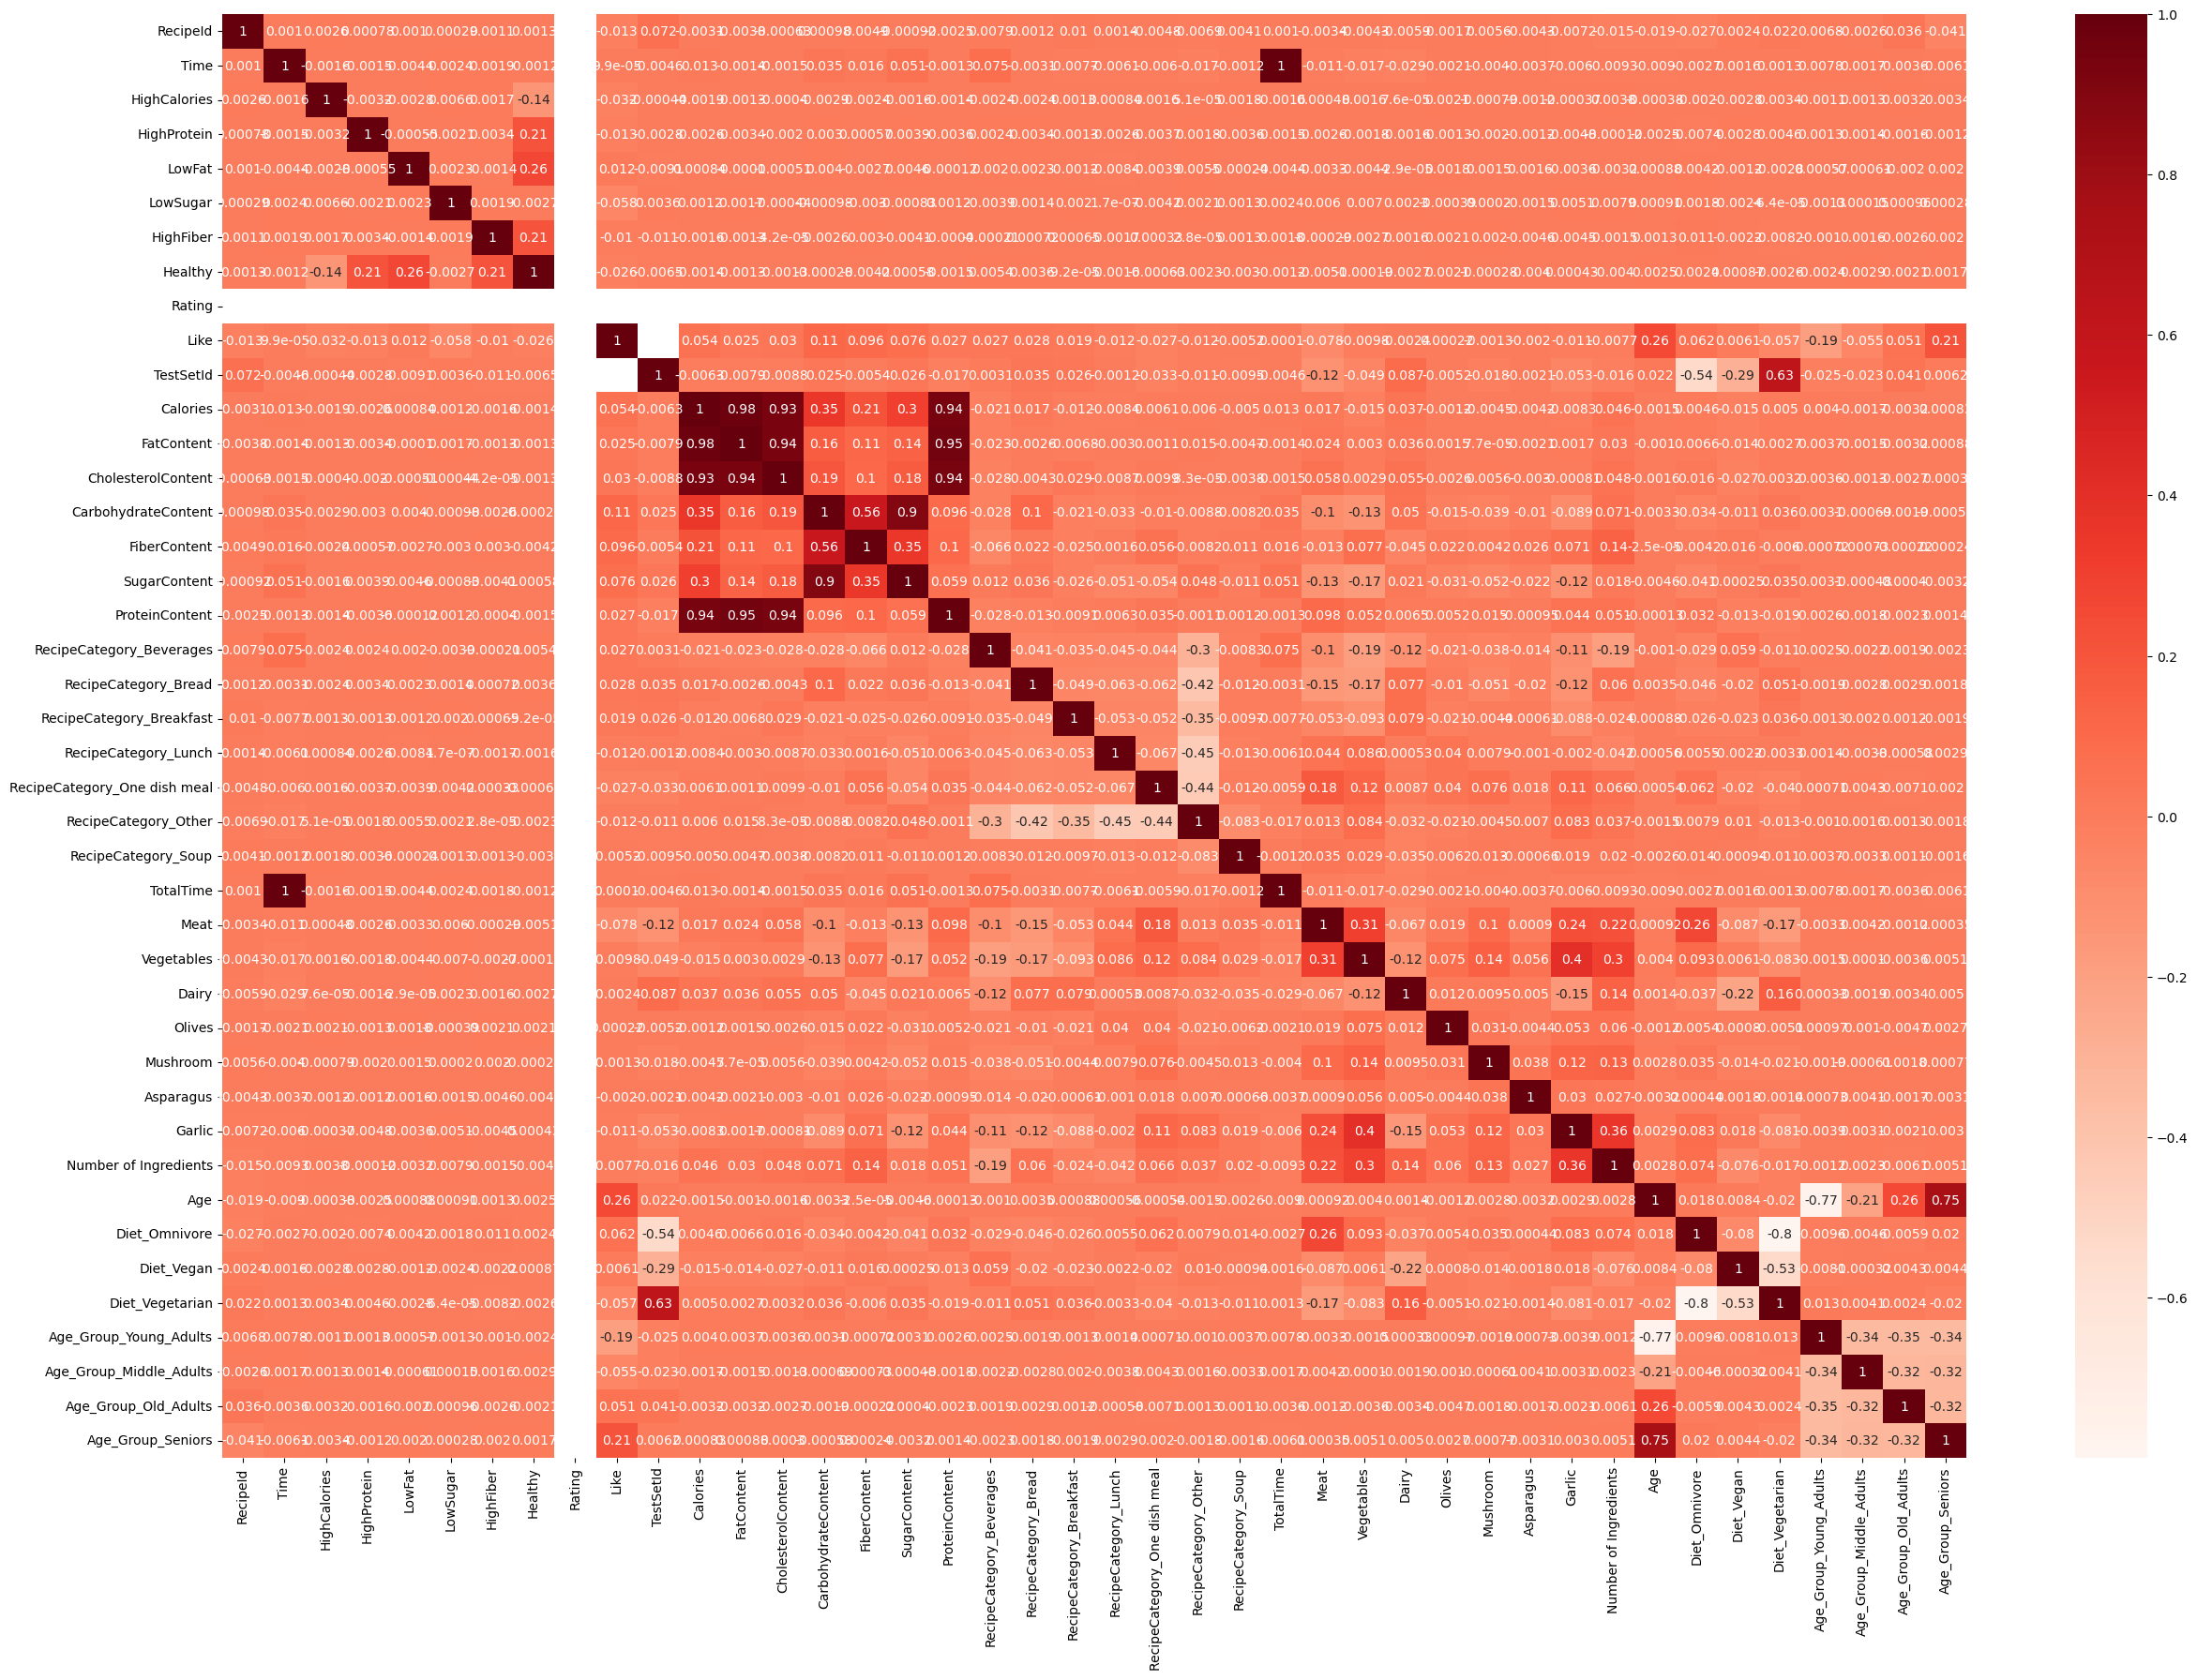

In [2352]:
# show any correlations between the variables
corr = full_df.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

## Cross feature engineering

In [2353]:
# Engineer complexity
full_df = full_df.assign(complex_to_cook = np.where((full_df['TotalTime'] > 1800) & (full_df['Number of Ingredients'] >= 15), 1, 0))

full_df = full_df.assign(easy_to_cook = np.where((full_df['TotalTime'] <= 900) & (full_df['Number of Ingredients'] <= 7), 1, 0))

# make column medium_to_cook if not complex and not easy
full_df = full_df.assign(medium_to_cook = np.where((full_df['complex_to_cook'] == 0) & (full_df['easy_to_cook'] == 0), 1, 0))

In [2354]:
# TimeRequestFulfilled -> 1, if TotalTime is less Time
#full_df = full_df.assign(TimeRequestFulfilled = np.where(full_df['TotalTime'] <= full_df['Time'], 1, 0))

/Users/marceldietl/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


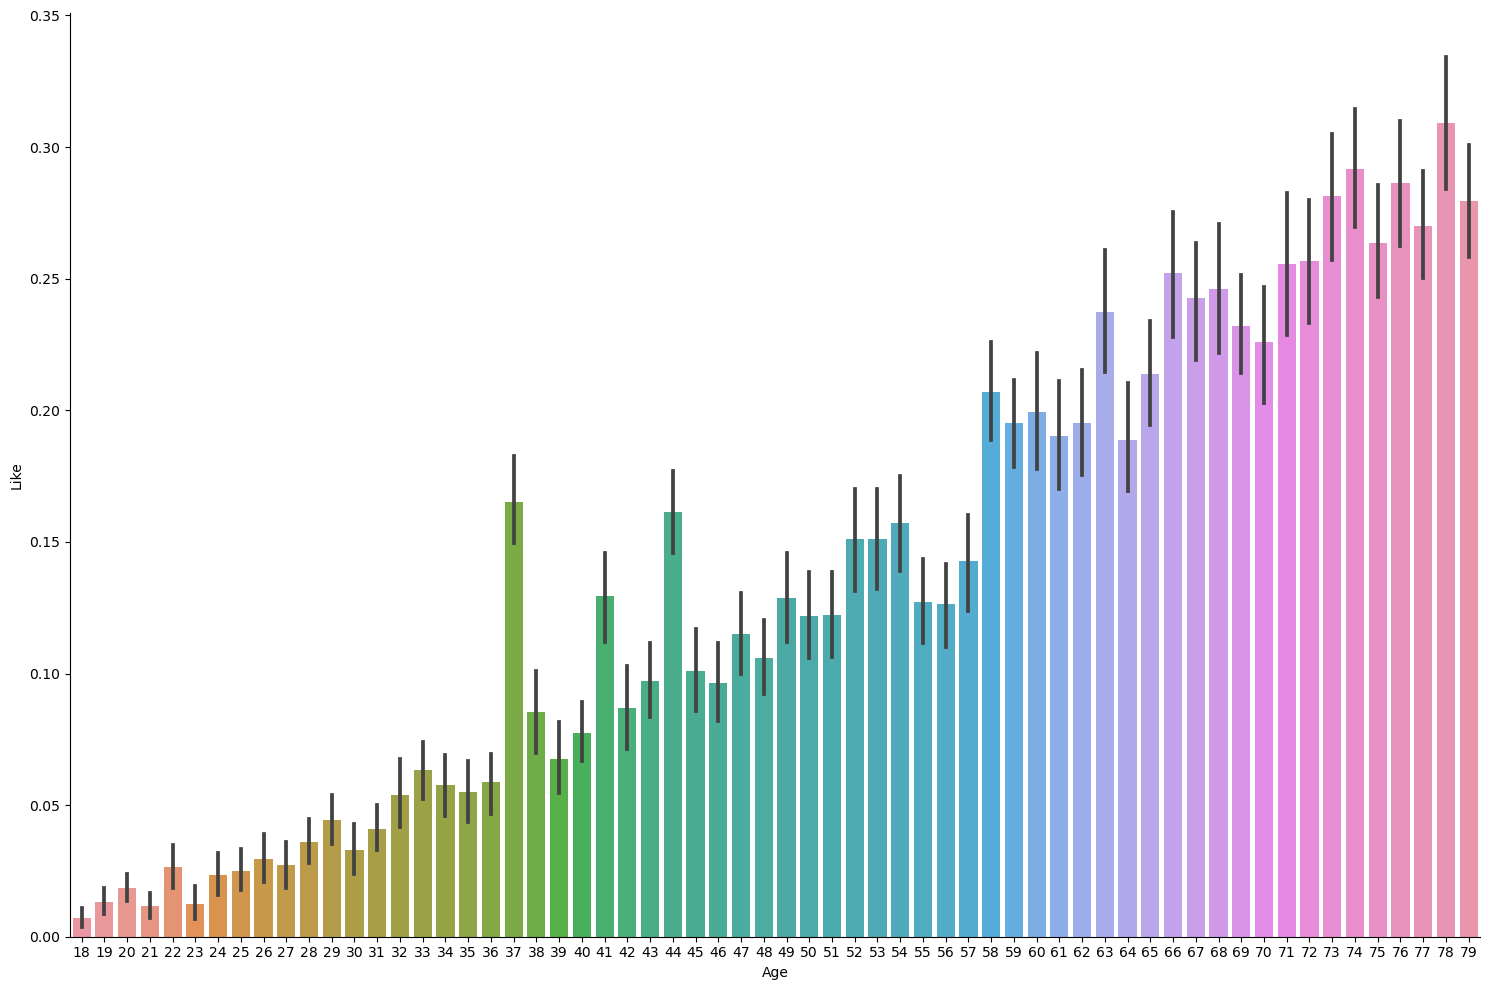

In [2355]:
# plot age against like

sns.catplot(x="Age", y="Like", data=full_df, kind="bar", height=10, aspect=1.5)
plt.show()

In [2356]:
# show me the requests of people age 18 and like 1
full_df[(full_df['Age'] == 78) & (full_df['Like'] == 1)]['RecipeCategory_Beverages'].value_counts()

0    390
1     11
Name: RecipeCategory_Beverages, dtype: int64

In [2357]:
# for each age, create a column that show the mean of the like column

#full_df['Age_Like_Ratio'] = full_df.groupby('Age')['Like'].transform('mean')




In [2358]:
# make a new column that shows the ratio of likes to dislikes for Age_Group_young_adults

# full_df['Like_Ratio_Young_Adults'] = full_df.groupby('Age_Group_Young_Adults')['Like'].transform(lambda x: x.sum() / x.count())
# full_df['Like_Ratio_Middle_Adults'] = full_df.groupby('Age_Group_Middle_Adults')['Like'].transform(lambda x: x.sum() / x.count())
# full_df['Like_Ratio_Old_Adults'] = full_df.groupby('Age_Group_Old_Adults')['Like'].transform(lambda x: x.sum() / x.count())
# full_df['Like_Ratio_Seniors'] = full_df.groupby('Age_Group_Seniors')['Like'].transform(lambda x: x.sum() / x.count())

In [2359]:
# full_df['Like_Ratio_Young_Adults'] = full_df[full_df['Age_Group_Young_Adults'] == 1]['Like'].mean()
# full_df['Like_Ratio_Middle_Adults'] = full_df[full_df['Age_Group_Middle_Adults'] == 1]['Like'].mean()
# full_df['Like_Ratio_Old_Adults'] = full_df[full_df['Age_Group_Old_Adults'] == 1]['Like'].mean()
# full_df['Like_Ratio_Seniors'] = full_df[full_df['Age_Group_Seniors'] == 1]['Like'].mean()

In [2360]:
# describe the Time column for Age Group Young Adults

# print(full_df[full_df['Age_Group_Young_Adults'] == 1]['Like'].mean())
# print(full_df[full_df['Age_Group_Middle_Adults'] == 1]['Like'].mean())
# print(full_df[full_df['Age_Group_Old_Adults'] == 1]['Like'].mean())
# print(full_df[full_df['Age_Group_Seniors'] == 1]['Like'].mean())

In [2361]:
# short time, many ingredients -> creative -> BRINGT NICHTS!!!
#full_df = full_df.assign(creative = np.where((full_df['TotalTime'] <= 900) & (full_df['Number of Ingredients'] >= 10), 1, 0))

In [2362]:
# Combine age and nutrients -> BRINGT NICHTS!!!

#full_df = full_df.assign(young_high_protein = np.where((full_df['Age_Group_Young_Adults'] == 1) & (full_df['ProteinContent'] >= 25), 1, 0))

In [2363]:
# are diet requests fulfilled? -> BRINGT NICHTS!!!

# VegeterianRequestFulfilled
#full_df = full_df.assign(VegeterianRequestNotFulfilled = np.where((full_df['Diet_Vegetarian'] == 1) & (full_df['Meat'] == 0), 1, 0))

#VeganRequestFulfilled -> 
#full_df = full_df.assign(VeganRequesFulfilled = np.where((full_df['Diet_Vegan'] == 1) & ((full_df['Meat'] == 0) & (full_df['Dairy'] == 0)), 1, 0))

# OmnivoreRequestFulfilled -> Makes no sense since omnivore eat everything
#full_df = full_df.assign(OmnivoreRequestFulfilled = np.where((full_df['Diet_Omnivore'] == 1) & (full_df['Meat'] == 1), 1, 0))

In [2364]:
# HighProteinRequestFulfilled -> BRINGT NICHTS!!!
#full_df = full_df.assign(HighProteinRequestFulfilled = np.where((full_df['HighProtein'] == 1) & (full_df['ProteinContent'] >= 25), 1, 0))
#full_df = full_df.assign(HighProteinRequestFulfilled = np.where((full_df["HighProtein"] == 0) & (full_df['ProteinContent'] < 25), 1, 0))

In [2365]:
# HighFiberRequestFulfilled -> 1, if FiberContent is more than 10
full_df = full_df.assign(HighFiberRequestFulfilled = np.where((full_df['HighFiber'] == 1) & (full_df['FiberContent'] >= 2.5), 1, 0))
full_df = full_df.assign(HighFiberRequestFulfilled = np.where((full_df['HighFiber'] == 0) & (full_df['FiberContent'] < 2.5), 1, 0))

In [2366]:
# describe the data in the FatContent column   
#full_df['FiberContent'].describe()

In [2367]:
# LowFatRequestFulfilled -> 1, if LowFat is 1, and FatContent is less than 3
full_df = full_df.assign(LowFatRequestFulfilled = np.where((full_df['LowFat'] == 1) & (full_df['FatContent'] < 13), 1, 0))
full_df = full_df.assign(LowFatRequestFulfilled = np.where((full_df['LowFat'] == 0) & (full_df['FatContent'] >= 13), 1, 0))

In [2368]:
# High Calories -> 1, if HighCalories is 1 and if CaloriesContent is more than 500 
#full_df = full_df.assign(HighCaloriesRequestFulfilled = np.where((full_df["HighCalories"] == 1) & (full_df['Calories'] >= 320), 1, 0))
#full_df = full_df.assign(HighCaloriesRequestFulfilled = np.where((full_df["HighCalories"] == 0) & (full_df['Calories'] < 320), 1, 0))

In [2369]:
# LowSugarRequestFulfilled -> 1, if LowSugar is 1, and SugarContent is less than 5
#full_df = full_df.assign(LowSugarRequestFulfilled = np.where((full_df['LowSugar'] == 1) & (full_df['SugarContent'] < 22), 1, 0))
#full_df = full_df.assign(LowSugarRequestFulfilled = np.where((full_df['LowSugar'] == 0) & (full_df['SugarContent'] >= 22), 1, 0))

# BRINGT NICHTS!!!

In [2370]:
# unhealthy nutrients
full_df["total_unhealthy_grams"] = full_df["FatContent"] + full_df["CarbohydrateContent"]

In [2371]:
recipes_cleaned["TotalGrams"] = recipes_cleaned["FatContent"] + recipes_cleaned["ProteinContent"] + recipes_cleaned["CarbohydrateContent"]

In [2372]:
# unhealty micros soudium, cholesterol -> BRINGT NICHTS!!!
#full_df["total_unhealthy_grams"] = full_df["SodiumContent"] + full_df["CholesterolContent"]

In [2373]:
# healthy nutrients -> BRINGT NICHTS!!!
# full_df["total_healthy_grams"] = full_df["ProteinContent"] + full_df["FiberContent"]

In [2374]:
full_df['Calories'].describe()

count    140195.000000
mean        488.321318
std        1785.987020
min           0.000000
25%         175.800000
50%         317.500000
75%         530.600000
max      350473.100000
Name: Calories, dtype: float64

In [2375]:
# from full_df, drop all rows where Age_Group_Young_Adults, Age_Group_Middle_Adults, Age_Group_Old_Adults is 1 

#full_df.drop(full_df[(full_df['Age_Group_Young_Adults'] == 1) | (full_df['Age_Group_Middle_Adults'] == 1) | (full_df['Age_Group_Old_Adults'] == 1)].index, inplace=True)

In [2376]:
full_df["TimeDifference"] = full_df["Time"] - full_df["TotalTime"]

In [2377]:
# make new feature based on Age and FatContent
full_df = full_df.assign(YoungHighProtein = np.where((full_df['Age_Group_Young_Adults'] == 1) & (full_df['FatContent'] >= 13), 1, 0))
full_df = full_df.assign(MiddleHighProtein = np.where((full_df['Age_Group_Middle_Adults'] == 1) & (full_df['FatContent'] >= 13), 1, 0))
full_df = full_df.assign(OldHighProtein = np.where((full_df['Age_Group_Old_Adults'] == 1) & (full_df['FatContent'] >= 13), 1, 0))
full_df = full_df.assign(SeniorsHighProtein = np.where((full_df['Age_Group_Seniors'] == 1) & (full_df['FatContent'] >= 13), 1, 0))

## Splitting dataset

In [2378]:
full_df_submission = full_df[full_df["Like"].isnull()]
full_df_modelling = full_df[full_df["Like"].notnull()]

## Create Train and Test 

In [2379]:
from sklearn.model_selection import train_test_split


X = full_df_modelling.drop(["AuthorId", "RecipeId", "Like", "TestSetId", "Time", "TotalTime", "Rating"], axis=1)
y = full_df_modelling["Like"]

X_train, X_test, y_train, y_test = \
  train_test_split(X, y,
                   test_size=0.3, 
                   shuffle=True,
                   random_state=seed)

# sample_weights = np.ones_like(y_train)
# sample_weights[X_train['Age'] >= 74] = 5
# sample_weights = sample_weights.astype(int)

# # Duplicate or replicate samples based on sample weights
# X_train_weighted = np.repeat(X_train.values, sample_weights, axis=0)
# y_train_weighted = np.repeat(y_train.values, sample_weights, axis=0)

In [2380]:
X_train.columns

Index(['HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber',
       'Healthy', 'Calories', 'FatContent', 'CholesterolContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeCategory_Beverages', 'RecipeCategory_Bread',
       'RecipeCategory_Breakfast', 'RecipeCategory_Lunch',
       'RecipeCategory_One dish meal', 'RecipeCategory_Other',
       'RecipeCategory_Soup', 'Meat', 'Vegetables', 'Dairy', 'Olives',
       'Mushroom', 'Asparagus', 'Garlic', 'Number of Ingredients', 'Age',
       'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian',
       'Age_Group_Young_Adults', 'Age_Group_Middle_Adults',
       'Age_Group_Old_Adults', 'Age_Group_Seniors', 'complex_to_cook',
       'easy_to_cook', 'medium_to_cook', 'TimeRequestFulfilled',
       'HighFiberRequestFulfilled', 'LowFatRequestFulfilled',
       'total_unhealthy_grams', 'TimeDifference', 'YoungHighProtein',
       'MiddleHighProtein', 'OldHighProtein', 'SeniorsHighProtein'],
 

## Decision Tree

0.7182118278412697
confusion matrix
[[23265  2047]
 [ 1884  2019]]
classification report
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     25312
         1.0       0.50      0.52      0.51      3903

    accuracy                           0.87     29215
   macro avg       0.71      0.72      0.71     29215
weighted avg       0.87      0.87      0.87     29215



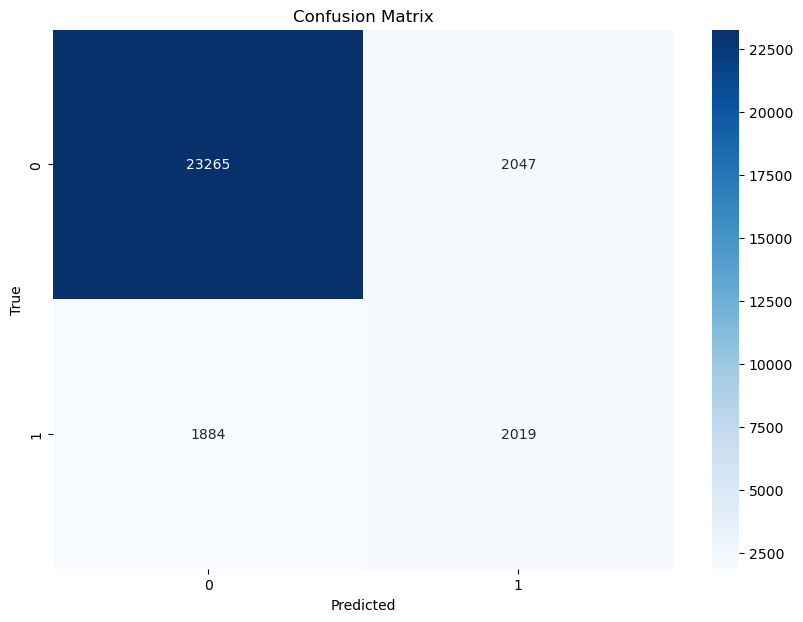

In [2381]:
# Run a decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Create the model
dt = DecisionTreeClassifier(random_state=seed)

# Fit the model
dt.fit(X_train, y_train)

predictions = dt.predict(X_test)

# Calculate the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

# Evaluate model
print("confusion matrix")
print(confusion_matrix(y_test, predictions))
print("classification report")
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [2382]:
feature_importances = dt.feature_importances_

features = X.columns
importance_scores = zip(features, feature_importances)
sorted_scores = sorted(importance_scores, key=lambda x: x[1], reverse=True)

# Print sorted feature importances
print("Feature Importances:")
for feature, score in sorted_scores:
    print(f"{feature}: {score}")

Feature Importances:
Age: 0.11791443998060828
ProteinContent: 0.09713456192583483
FatContent: 0.08705018209302
Calories: 0.06697656467882125
HighProtein: 0.06488503718609306
CarbohydrateContent: 0.061914296406956365
LowFat: 0.055141948061339006
FiberContent: 0.05205071455694519
SugarContent: 0.05046582117431976
CholesterolContent: 0.048134332856679715
total_unhealthy_grams: 0.04033322598561755
Number of Ingredients: 0.03487467549279532
Meat: 0.028299535871595775
HighCalories: 0.026149215021501294
TimeDifference: 0.02432419916917243
Diet_Omnivore: 0.017043411357848804
LowSugar: 0.012811624894144722
HighFiber: 0.0099877768467847
Diet_Vegetarian: 0.008579831936815328
LowFatRequestFulfilled: 0.00801150494543243
RecipeCategory_One dish meal: 0.007897470401421526
RecipeCategory_Beverages: 0.007765215412598532
RecipeCategory_Other: 0.007077928858096705
TimeRequestFulfilled: 0.0064986899909325845
Dairy: 0.0058661745806798385
HighFiberRequestFulfilled: 0.00572944947766742
Garlic: 0.005178582537

## Random Forest

In [2383]:
# Random Forest: 

from sklearn.ensemble import RandomForestClassifier


# Fit Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=50, random_state=seed, max_depth=None)
rf_model.fit(X_train, y_train)

# Make predictions
predictions = rf_model.predict(X_test)

# Evaluate model
print("confusion matrix")
print(confusion_matrix(y_test, predictions))
print("classification report")
print(classification_report(y_test, predictions))

# Calculate balanced accuracy
print("balanced accuracy score")
print(balanced_accuracy_score(y_test, predictions))

count_1s = np.count_nonzero(predictions == 1)
count_0s = np.count_nonzero(predictions == 0)

print()
print(f"Number of 1s: {count_1s}")
print(f"Number of 0s: {count_0s}")

confusion matrix
[[24933   379]
 [ 2689  1214]]
classification report
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     25312
         1.0       0.76      0.31      0.44      3903

    accuracy                           0.89     29215
   macro avg       0.83      0.65      0.69     29215
weighted avg       0.88      0.89      0.88     29215

balanced accuracy score
0.6480348261637374

Number of 1s: 1593
Number of 0s: 27622


## GradientBooster

In [2384]:
# # Run the GradientBooster2000
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import balanced_accuracy_score

# # Create the model
# gb_model = GradientBoostingClassifier(n_estimators=4000)

# # Fit the model
# gb_model.fit(X_train, y_train)

# predictions = gb_model.predict(X_test)

# # Calculate the balanced accuracy score
# print(balanced_accuracy_score(y_test, predictions))

# # Evaluate model
# print("confusion matrix")
# print(confusion_matrix(y_test, predictions))
# print("classification report")
# print(classification_report(y_test, predictions))

# cm = confusion_matrix(y_test, predictions)

# # Plotting using seaborn for better visualization
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# searching for best model
#   1. LogisticRegression
#   2. RandomForestClassifier
#   3. GradientBoostingClassifier
#   4. SVC/SVM  --> Powerful, particularly effective in high-dimensional spaces.
#   5. KNeighborsClassifier (KNN)   --> based on the majority of k-nearest neighbors.
#   6. DecisionTreeClassifier   --> based on the partitioning of the feature space.
#   7. GaussianNB (Naive Bayes) --> Simple probabilistic classifier based on Bayes's theorem.
#   8. MLPClassifier (Neural Network)   --> Multilayer Perceptron, a simple neural network.
#   9. K-Means  --> grouping data points into k clusters.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# initialize models
model_logistic_regression = LogisticRegression(max_iter=1000)
model_random_forest = RandomForestClassifier()
model_gradient_boosting = GradientBoostingClassifier()
model_svm = SVC(max_iter=100)
model_knn = KNeighborsClassifier()
model_decision_tree = DecisionTreeClassifier(random_state=seed)
model_naive_bayes = GaussianNB()
model_nn = MLPClassifier(max_iter=1000)

# pipeline
pipeline = Pipeline(steps=[
                #            ("scaler", transform_scaler), 
                 #          ("pca", transform_pca),
                           ("model", None)
])

# choose PCA n_components
parameter_grid_preprocessing = {
  "pca__n_components" : [1, 2, 3, 4],
}

# Parameter grids for each model
parameter_grid_logistic_regression = {
  "model" : [model_logistic_regression],
  "model__C" : [0.1, 1, 10],  # inverse regularization strength
}

parameter_grid_gradient_boosting = {
  "model" : [model_gradient_boosting],
  "model__n_estimators" : [1000]
}

parameter_grid_random_forest = {
  "model" : [model_random_forest],
  "model__n_estimators" : [3, 50, 80],  # number of max trees in the forest
  "model__max_depth" : [None, 50, 100],
}

parameter_grid_svm = {
    "model": [model_svm],
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf"],
}

parameter_grid_knn = {
    "model": [model_knn],
    "model__n_neighbors": [3, 5, 7],
}

parameter_grid_decision_tree = {
    "model": [model_decision_tree],
#    "model__criterion": ['gini', 'entropy'],
#    "model__max_depth": [None, 10, 50, 100],
#    "model__min_samples_split": [2, 5, 10],
#    "model__min_samples_leaf": [1, 2, 4],
}

parameter_grid_naive_bayes = {
    "model": [model_naive_bayes],
}

parameter_grid_nn = {
    "model": [model_nn],
    "model__hidden_layer_sizes": [(50, 50), (100,)],
}

# choose models for pipeline
meta_parameter_grid = [
                       parameter_grid_logistic_regression,
                #      parameter_grid_gradient_boosting,
                       parameter_grid_random_forest,
                       parameter_grid_svm,
                       parameter_grid_knn,
                       parameter_grid_decision_tree,
                       parameter_grid_naive_bayes,
                       parameter_grid_nn
]

# choose whether preprocessing or not
#meta_parameter_grid = [{**parameter_grid_preprocessing, **model_grid}
#                       for model_grid in meta_parameter_grid]

search = GridSearchCV(pipeline,
                      meta_parameter_grid, 
                      scoring="balanced_accuracy",
                      n_jobs=8,     # number of kernels on your Mac
                      cv=5,         # number of folds for cross-validation 
                      error_score="raise"
)
# here, the actual training and grid search happens
search.fit(X_train, y_train.values.ravel())

print("best parameter:", search.best_params_ ,"(CV score=%0.3f)" % search.best_score_)

In [ ]:
# for a detailed look on the performance of the different models
def get_search_score_overview():
  for c,s in zip(search.cv_results_["params"],search.cv_results_["mean_test_score"]):
      print(c, s)

print(get_search_score_overview())